In [1]:
import os
import glob
import json
import cv2
import numpy as np
import torch
from PIL import Image, ImageDraw
from tqdm import tqdm
import matplotlib.pyplot as plt

# CoTrackerのロード
cotracker = torch.hub.load("facebookresearch/co-tracker", "cotracker3_offline").cuda()

Using cache found in /data2/yoshimura/.cache/torch/hub/facebookresearch_co-tracker_main


In [2]:
def extract_frames(video_path):    
    """
    動画ファイルを読み込んで、初期フレームと全体の動画フレーム数の2/3進んだフレームを切り取る。

    Args:
        video_path (str): 動画ファイルのパス。

    Returns:
        tuple: 初期フレーム（numpy array）と2/3位置のフレーム（numpy array）。
    """
    # 動画ファイルを読み込む
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"動画ファイル {video_path} を開けませんでした。")
    
    # 総フレーム数を取得
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames < 1:
        raise ValueError("動画のフレーム数が無効です。")
    
    # 初期フレーム（0番目）を取得
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    ret, first_frame = cap.read()
    if not ret:
        raise ValueError("初期フレームの取得に失敗しました。")
    
    # 全体の2/3進んだフレームを取得
    two_thirds_frame_index = int(total_frames * 2 / 3)
    cap.set(cv2.CAP_PROP_POS_FRAMES, two_thirds_frame_index)
    ret, two_thirds_frame = cap.read()
    if not ret:
        raise ValueError(f"フレーム {two_thirds_frame_index} の取得に失敗しました。")
    
    # 動画を解放
    cap.release()
    
    first_frame = cv2.resize(first_frame, (416, 416))
    two_thirds_frame = cv2.resize(two_thirds_frame, (416, 416))
    
    return first_frame, two_thirds_frame

In [3]:
data_path = "/data2/yoshimura/mirror_detection/DATA/videos_demo/PXL_20241008_050855851.mp4"
first_frame, two_thirds_frame = extract_frames(data_path)
print(first_frame.shape, two_thirds_frame.shape)

(416, 416, 3) (416, 416, 3)


In [4]:
resize_tuple = (416, 416)
first_frame_torch = torch.tensor(cv2.resize(first_frame, resize_tuple)).permute(2, 0, 1).float().cuda()
two_thirds_frame_torch = torch.tensor(cv2.resize(two_thirds_frame, resize_tuple)).permute(2, 0, 1).float().cuda()
frames = torch.stack([first_frame_torch, two_thirds_frame_torch]).unsqueeze(0)
print(frames.shape)
print(frames.dtype)
print(frames.max(), frames.min())

torch.Size([1, 2, 3, 416, 416])
torch.float32
tensor(255., device='cuda:0') tensor(0., device='cuda:0')


In [5]:
device = 'cuda'
grid_size = 52

pred_tracks, pred_visibility = cotracker(frames, grid_size=grid_size) # B T N 2,  B T N 1
pred_tracks.shape

torch.Size([1, 2, 2704, 2])

In [6]:
def plot_points_on_image(image, points, color=(0, 255, 0), radius=2):
    """
    指定された点を画像にプロットします。

    Args:
        image (numpy.ndarray): 形状 (416, 416, 3) の画像。
        points (numpy.ndarray): 形状 (52, 52, 2) の位置座標が入った配列。
        color (tuple): プロットする点の色 (B, G, R)。
        radius (int): プロットする点の半径。

    Returns:
        numpy.ndarray: 点をプロットした画像。
    """
    # 画像のコピーを作成
    assert image.dtype == np.uint8
    image_with_points = image.copy()

    # 52x52 の点を画像上にプロット
    for y in range(points.shape[0]):  # 52
        for x in range(points.shape[1]):  # 52
            # 各点の座標 (x, y)
            coord = points[y, x]
            # OpenCV は (x, y) 順で指定する
            cv2.circle(image_with_points, (int(coord[0]), int(coord[1])), radius, color, -1)
    
    return image_with_points

In [7]:
print(first_frame.shape)
print(first_frame.dtype)

(416, 416, 3)
uint8


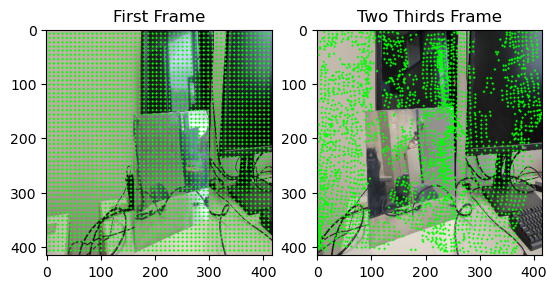

In [8]:
pred_tracks = pred_tracks.reshape(-1, 2, grid_size, grid_size, 2)

pred_tracks_0 = pred_tracks[0, 0] # (52, 52, 2)
pred_tracks_1 = pred_tracks[0, 1]

first_frame_with_points = plot_points_on_image(first_frame, pred_tracks_0.cpu().numpy(), color=(0, 255, 0))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(first_frame_with_points, cv2.COLOR_BGR2RGB))
plt.title("First Frame")

two_thirds_frame_with_points = plot_points_on_image(two_thirds_frame, pred_tracks_1.cpu().numpy(), color=(0, 255, 0))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(two_thirds_frame_with_points, cv2.COLOR_BGR2RGB))
plt.title("Two Thirds Frame")

plt.show()
plt.close()

# 矢印の

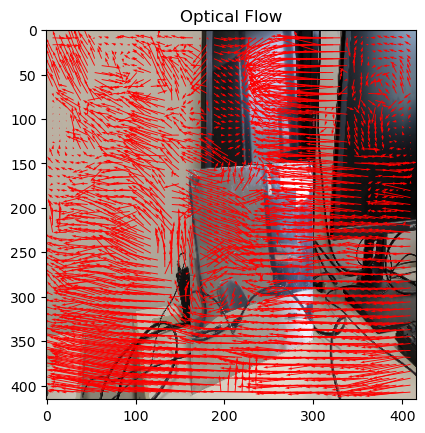

In [9]:
flow = pred_tracks_1 - pred_tracks_0   # (52, 52, 2)

plt.imshow(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB))
plt.quiver(pred_tracks_0[:, :, 0].cpu().numpy(), pred_tracks_0[:, :, 1].cpu().numpy(), flow[:, :, 0].cpu().numpy(), flow[:, :, 1].cpu().numpy(), color='r', angles='xy', scale_units='xy', scale=1)
plt.title("Optical Flow")
plt.show()
plt.close()
